In [1]:
import pandas as pd
import requests
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import random as rd
import statsmodels.api as sm 
import pmdarima as pmd
import seaborn as sns
import xml.etree.ElementTree as ET

# General parameters 

In [2]:
# End = Day to forecast
end = '2023-09-01'
# Number of days for training the models [days]
dt_train = 5
# Length of the forecast [hours]
T=48

# Get data for FCR-D historical prices

Prices and volume data for FCR-D up and down (from Energidata)

See https://www.energidataservice.dk/tso-electricity/FcrNdDK2 

In [3]:
# Parameters specific to Energidata and ENTSO
area = 'DK2'
area_wind = 'DK2'                                                       
auction = 'D-1 early'

# start_api = end - T - dt_train
start_api = datetime.strftime(datetime.strptime(end, '%Y-%m-%d') \
                        + pd.Timedelta(days = -dt_train, hours = -T), '%Y-%m-%d') 
# for energidata and entso, data does not include the end day --> creates end_api = end + 1day to use in the request     
end_api = (datetime.strptime(end, '%Y-%m-%d') + pd.Timedelta(days=1)).strftime('%Y-%m-%d')

Get data from Energidata for FCR-D up and down prices (data includes training data and data for the day to forecast)

Returns a pandas dataframe: 'HourDK', 'ProductName', 'PriceTotalEUR'
(prices are in EUR/MW)

In [4]:
response_data = requests.get(
    url = f'https://api.energidataservice.dk/dataset/FcrNdDK2?start={start_api}&end={end_api}&filter={{"PriceArea":["{area}"],"AuctionType":["{auction}"]}}&timezone=DK') 
results_data = response_data.json()
records_data = results_data.get('records',[])

# Dataframe with all data                             
df_fcr = pd.DataFrame(records_data)[['HourDK','ProductName', 'PriceTotalEUR']]
df_fcr['HourDK'] = pd.to_datetime(df_fcr['HourDK'], format='%Y-%m-%dT%H:%M:%S')

# Look for missing data (example: day with time change) and assign zero
dates = pd.date_range(start = pd.to_datetime(start_api), end = datetime.strptime(end_api, '%Y-%m-%d') + pd.Timedelta(hours = -1), freq = 'H')
print('Missing Data: \n', dates.difference(df_fcr['HourDK']))
for missing in dates.difference(df_fcr['HourDK']): 
    df = pd.DataFrame({'HourDK': [pd.to_datetime(missing) for i in range(0,3)],
                        'ProductName': ['FCR-D ned', 'FCR-d downp', 'FCR-N'],
                        'PriceTotalEUR': [0, 0, 0]})
    df_fcr = pd.concat([df_fcr,df], ignore_index=True)
print('\nPrices data: \n',  df_fcr.head())

Missing Data: 
 DatetimeIndex([], dtype='datetime64[ns]', freq=None)

Prices data: 
                HourDK ProductName  PriceTotalEUR
0 2023-09-01 23:00:00   FCR-D ned       64.31977
1 2023-09-01 23:00:00   FCR-D upp       35.69323
2 2023-09-01 23:00:00       FCR-N       58.28345
3 2023-09-01 22:00:00   FCR-D ned       64.25239
4 2023-09-01 22:00:00   FCR-D upp       35.70882


Creates dataframes df_volume_up and df_volume_down for total and local purchased volume for FCR-D up and down

In [5]:
df_volume = pd.DataFrame(records_data)[['HourDK','ProductName', 'PurchasedVolumeLocal', 'PurchasedVolumeTotal']] 

df_volume_up = df_volume.loc[df_volume['ProductName'] == 'FCR-D upp'].copy()
df_volume_up = df_volume_up[['HourDK', 'PurchasedVolumeLocal', 'PurchasedVolumeTotal']]
df_volume_up['HourDK'] = pd.to_datetime(df_volume_up['HourDK'], format='%Y-%m-%dT%H:%M:%S')
df_volume_up = df_volume_up.drop(df_volume_up.loc[df_volume_up['HourDK'].duplicated() == True].index)
df_volume_up = df_volume_up.drop(df_volume_up.loc[df_volume_up['PurchasedVolumeTotal'] == 0].index)
df_volume_up = df_volume_up.set_index('HourDK')
print('Purchased volume for FCR-D up: \n', df_volume_up.head())

df_volume_down = df_volume.loc[df_volume['ProductName'] == 'FCR-D ned'].copy()
df_volume_down = df_volume_down[['HourDK', 'PurchasedVolumeLocal', 'PurchasedVolumeTotal']]
df_volume_down['HourDK'] = pd.to_datetime(df_volume_down['HourDK'], format='%Y-%m-%dT%H:%M:%S')
df_volume_down = df_volume_down.drop(df_volume_down.loc[df_volume_down['HourDK'].duplicated() == True].index)
df_volume_down = df_volume_down.drop(df_volume_down.loc[df_volume_down['PurchasedVolumeTotal'] == 0].index)
df_volume_down = df_volume_down.set_index('HourDK')
print('\nPurchased volume for FCR-D down: \n', df_volume_down.head())

Purchased volume for FCR-D up: 
                      PurchasedVolumeLocal  PurchasedVolumeTotal
HourDK                                                         
2023-09-01 23:00:00                  12.2                 509.6
2023-09-01 22:00:00                  10.4                 503.8
2023-09-01 21:00:00                   9.3                 502.9
2023-09-01 20:00:00                   9.4                 512.4
2023-09-01 19:00:00                   9.2                 514.9

Purchased volume for FCR-D down: 
                      PurchasedVolumeLocal  PurchasedVolumeTotal
HourDK                                                         
2023-09-01 23:00:00                  18.7                 248.2
2023-09-01 22:00:00                  18.0                 247.3
2023-09-01 21:00:00                  18.3                 247.6
2023-09-01 20:00:00                  17.7                 258.1
2023-09-01 19:00:00                  17.7                 259.1


Creates dataframe with FCR-D up prices only

In [6]:
df_up = df_fcr.loc[df_fcr['ProductName'] == 'FCR-D upp'].copy()
df_up = df_up[['HourDK', 'PriceTotalEUR']]
df_up['HourDK'] = pd.to_datetime(df_up['HourDK'], format='%Y-%m-%d %H:%M:%S')
df_up.drop(df_up.loc[df_up['HourDK'].duplicated() == True].index, inplace=True)
df_up.set_index('HourDK', inplace=True)
print('FCR-D up prices: \n', df_up.head())

FCR-D up prices: 
                      PriceTotalEUR
HourDK                            
2023-09-01 23:00:00       35.69323
2023-09-01 22:00:00       35.70882
2023-09-01 21:00:00       35.74233
2023-09-01 20:00:00       36.08172
2023-09-01 19:00:00       36.08867


Creates dataframe with FCR-D down prices only

In [7]:
df_down = df_fcr.loc[df_fcr['ProductName'] == 'FCR-D ned'].copy()
df_down = df_down[['HourDK', 'PriceTotalEUR']]
df_down['HourDK'] = pd.to_datetime(df_down['HourDK'], format='%Y-%m-%d %H:%M:%S')
df_down.drop(df_down.loc[df_down['HourDK'].duplicated() == True].index, inplace=True)
df_down.set_index('HourDK', inplace=True)
print('FCR-D down prices: \n', df_down.head())

FCR-D down prices: 
                      PriceTotalEUR
HourDK                            
2023-09-01 23:00:00       64.31977
2023-09-01 22:00:00       64.25239
2023-09-01 21:00:00       64.25076
2023-09-01 20:00:00       64.36900
2023-09-01 19:00:00       64.25069


Plot purchased volume against prices for FCR-D up and down

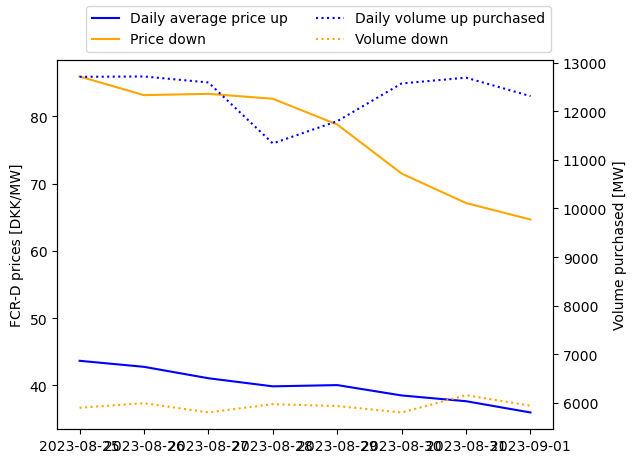

In [8]:
fig, axP = plt.subplots()
axV = plt.twinx(axP)
dataframes = [df_up,df_down,df_volume_up,df_volume_down]
names = ['df_up','df_down','df_volume_up','df_volume_down']
colors = ['blue', 'orange','blue', 'orange']
for df, name, color in zip(dataframes, names, colors): 
    if 'volume' in name: 
        df0 = df.resample('D').sum().copy()
        axV.plot(df0['PurchasedVolumeTotal'], linestyle = ':', color = color)
    else : 
        df0 = df.resample('D').mean().copy()
        axP.plot(df0['PriceTotalEUR'], color = color)
axP.set_ylabel('FCR-D prices [DKK/MW]')
axV.set_ylabel('Volume purchased [MW]')
fig.legend(['Daily average price up', 'Price down', 'Daily volume up purchased', 'Volume down'], ncol=2, loc='upper center')
plt.xticks(rotation = 90)
plt.show()

# Preliminary data analysis

Extract the data for prices to fit the SARIMA model.
 
Provide functions for transformation (exponential, log, diff etc.) 

Returns: plot of the hourly data, PACF for the prices, correlation matrix.   

In [9]:
start_fit = datetime.strptime(start_api, '%Y-%m-%d')    # (datetime) start for training/fitting the model 
end_fit = datetime.strptime(end,'%Y-%m-%d') + pd.Timedelta(days = +1, hours = -T-1)            # (timestamp) end for training/fitting the model (end of data - T)
dates_train = pd.date_range(start = start_fit, end = end_fit, freq = 'H')

# Service is 'up' or 'down' depending on what FCR-D products to forecast 
service = 'up'

Before fitting the model, it's possible to do transformations on the prices. Here as examples on the FCR-D down data: exponential, log, differenciation, averaging over 1day, box-cox ... 

For example, if the prices have exceptional peaks (like end of november/beginning of december).

To assess if it could improve the model, check the plots, PACF and the correlation matrix first before using it in the auto_arima function.

In [10]:
# Here examples for the FCR-D down prices data: 

# df_down = df_down.ewm(alpha=.05).mean()
# df_down = df_down.apply(lambda x : np.log(x))
# df_down = df_down.diff(periods = -1)
# df_down = df_down.resample('D').mean()

# x = stats.boxcox(df_down['PriceTotalEUR'].to_numpy())
# df_down['PriceTotalEUR'] = x[0]

Select data for fitting the SARIMA model

Creates pandas dataframe for prices variables for training and testing

In [11]:
# Dataframe of prices for fitting the SARIMA model
prices_train_up = df_up['PriceTotalEUR'][dates_train]
prices_train_down = df_down['PriceTotalEUR'][dates_train]
train_data = pd.DataFrame({'PriceTotalEUR_up' : prices_train_up, 'PriceTotalEUR_down' : prices_train_down})
print(train_data.head())

if service == 'up':
    prices_train = prices_train_up
elif service == 'down': 
    prices_train = prices_train_down
print(prices_train)

                     PriceTotalEUR_up  PriceTotalEUR_down
2023-08-25 00:00:00          43.75403            90.57656
2023-08-25 01:00:00          43.65644            90.89995
2023-08-25 02:00:00          43.61719            90.89734
2023-08-25 03:00:00          43.53542            90.69236
2023-08-25 04:00:00          43.72650            90.63516
2023-08-25 00:00:00    43.75403
2023-08-25 01:00:00    43.65644
2023-08-25 02:00:00    43.61719
2023-08-25 03:00:00    43.53542
2023-08-25 04:00:00    43.72650
                         ...   
2023-08-30 19:00:00    38.59991
2023-08-30 20:00:00    38.61235
2023-08-30 21:00:00    38.32179
2023-08-30 22:00:00    38.33413
2023-08-30 23:00:00    38.28977
Name: PriceTotalEUR, Length: 144, dtype: float64


Autocorrelation and PACF for the prices

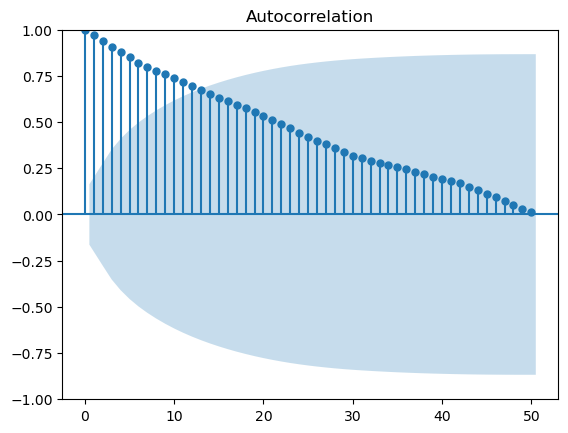

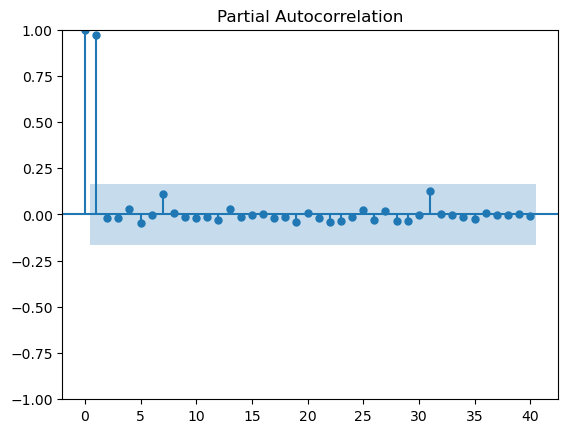

In [12]:
fig1 = sm.graphics.tsa.plot_acf(prices_train.values.squeeze(), lags = 50)
fig2 = sm.graphics.tsa.plot_pacf(prices_train,  lags = 40)
plt.show()

Plot all data available (prices, wind, solar, generation, load)

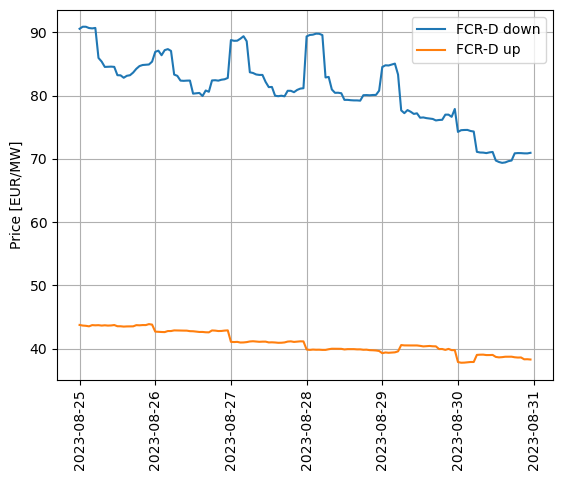

In [13]:
ticks = pd.date_range(start = dates_train[0], end = dates_train[-1] + pd.Timedelta(hours=+1), freq = 'D')

fig, ax = plt.subplots()
for price in [prices_train_down, prices_train_up]:
    ax.plot(dates_train, price)
ax.set_ylabel('Price [EUR/MW]')
plt.grid(visible=True)
plt.xticks(ticks, rotation = 90)
ax.legend(['FCR-D down', 'FCR-D up'])
plt.show()

# SARIMA model

If no orders for the model are given, it fits the a SARIMA model using pmd.auto_arima with a seasonal order of 24.

Returns: the SARIMA model with its parameters, a forecast for the day 'end' with confidence interval.  

Initializing the model orders

In [14]:
(p,d,q) = (None, None, None)
(P,D,Q,m) = (None, None, None, 24)

Creating and fitting the SARIMA model

In [15]:
# If the model orders are not known beforehand, use the auto_arima function (can take some time to run...) 
if any(order == None for order in [p,d,q,P,D,Q,m]): 
    arima_model = pmd.auto_arima(prices_train, seasonal=True, m=24, stepwise = True, maxiter = 100)
    (p,d,q) = arima_model.order
    (P,D,Q,m) = arima_model.seasonal_order
# If the model orders are known, use the pmd.ARIMA().fit function: 
else : 
    arima_model = pmd.ARIMA(order = (p,d,q), seasonal_order = (P,D,Q,m)).fit(prices_train, maxiter= 100)

Print the model orders, parameters, tests and residual diagnostics.

Model parameters:
 intercept   -0.061465
ar.L1        0.941228
ma.S.L24    -0.588286
sigma2       0.038006
dtype: float64

Model summary : 
                                       SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  144
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 24)   Log Likelihood                  19.912
Date:                              Fri, 29 Dec 2023   AIC                            -31.824
Time:                                      15:50:57   BIC                            -20.674
Sample:                                  08-25-2023   HQIC                           -27.296
                                       - 08-30-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------

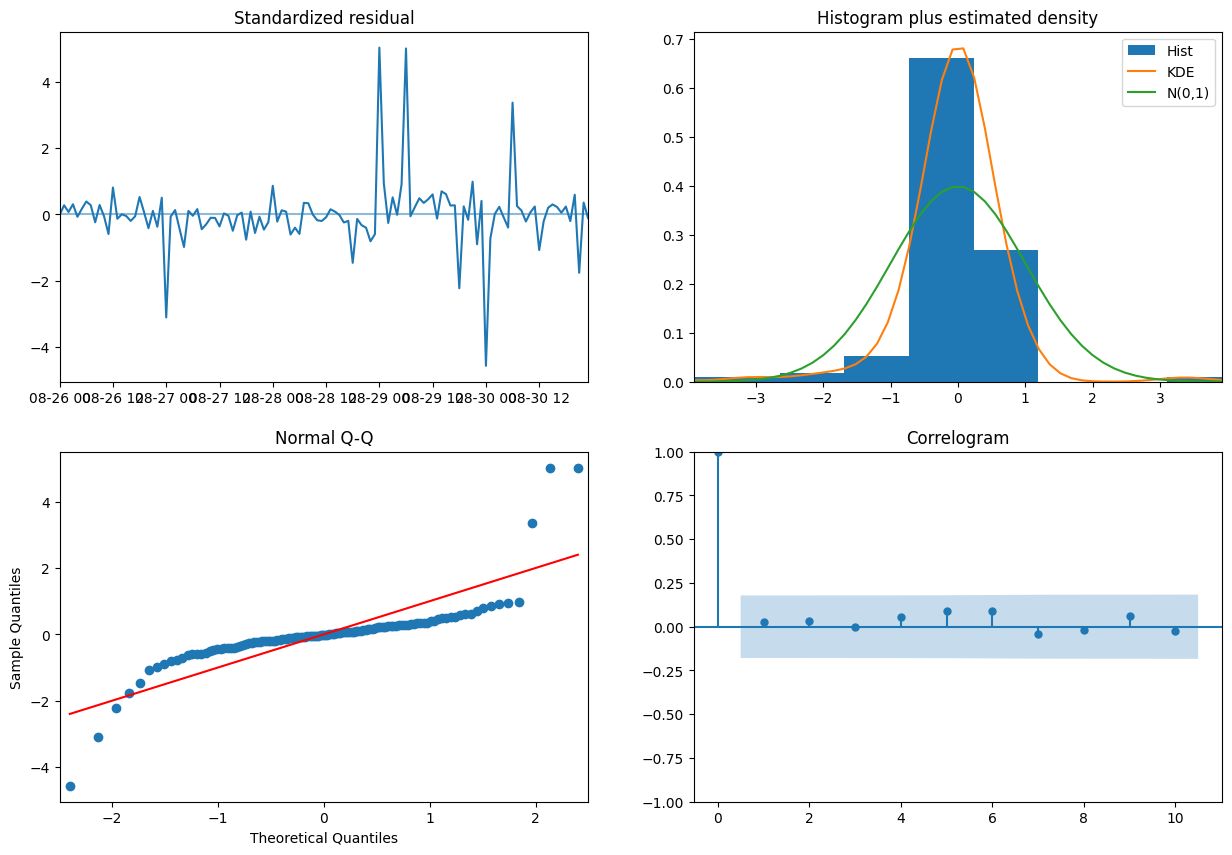

In [ ]:
print('Model parameters:\n', arima_model.params())
print('\nModel summary : \n', arima_model.summary())
print('\nModel diagnostics: \n', arima_model.plot_diagnostics(figsize=(15,10)))

Use the SARIMA model for prices forecast

In [ ]:
start_test = datetime.strptime(end, '%Y-%m-%d') + pd.Timedelta(days = +1, hours = -T)
end_test = datetime.strptime(end, '%Y-%m-%d') + pd.Timedelta(days = +1, hours = -1)
dates_test = pd.date_range(start = start_test, end = end_test, freq = 'H')

# Dataframe with prices data for the forecasted day
if service == 'up':
    prices_test = df_up['PriceTotalEUR'][dates_test]
elif service == 'down': 
    prices_test = df_down['PriceTotalEUR'][dates_test]

pred, conf_int = arima_model.predict(n_periods = T, return_conf_int =  True, alpha = .05) # alpha = .05 for a 95% confidence interval

Plot prices forecast with confidence interval against the real prices

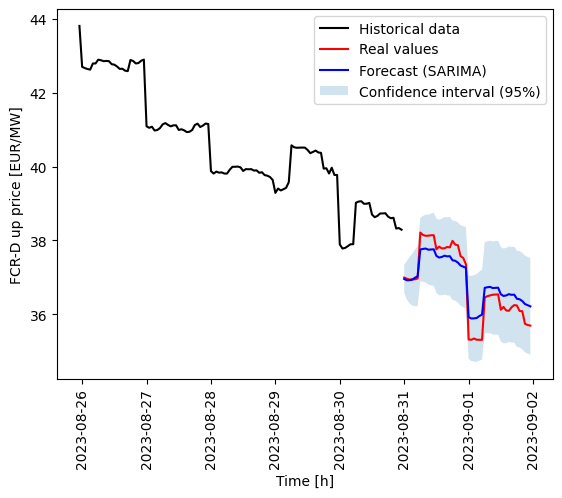

In [ ]:
x_data = pd.date_range(datetime.strftime(end_fit + pd.Timedelta(weeks=0, days = -5), '%Y-%m-%d 23:00:00') , datetime.strftime(end_fit, '%Y-%m-%d 23:00:00'), freq='H')
if service == 'up':
    y_data = df_up['PriceTotalEUR'][x_data]
elif service == 'down':
    y_data = df_down['PriceTotalEUR'][x_data]
x_forecast = pd.date_range(end_fit + pd.Timedelta(hours = +1), datetime.strptime(end + ' 23:00:00', '%Y-%m-%d %H:%M:%S'), freq='H')

fig_arima, ax_arima = plt.subplots()
# plot historical data
ax_arima.plot(x_data, y_data, color = 'black')
# plot real prices for that day
ax_arima.plot(x_forecast, prices_test, color = 'red')
# plot 24h pred and CI
ax_arima.plot(x_forecast, pred, color = 'blue')
ax_arima.fill_between(x_forecast, [conf_int[i][0] for i in range(len(conf_int))], [conf_int[i][1] for i in range(len(conf_int))], alpha=0.2)
ax_arima.legend(['Historical data', 'Real values', 'Forecast (SARIMA)', 'Confidence interval (95%)'])
ax_arima.set_ylabel('FCR-D ' + service +' price [EUR/MW]')
ax_arima.set_xlabel('Time [h]')
plt.xticks(rotation = 90)
plt.show()